# EE7209: Machine Learning Assignment 2

# Mobile Price Prediction Using Machine Learning

# EG/2017/3181 : KUMARI M.A.W.K

# Part 1

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/train(1).csv", dtype=np.float64)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   float64
 1   blue           2000 non-null   float64
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   float64
 4   fc             2000 non-null   float64
 5   four_g         2000 non-null   float64
 6   int_memory     2000 non-null   float64
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   float64
 9   n_cores        2000 non-null   float64
 10  pc             2000 non-null   float64
 11  px_height      2000 non-null   float64
 12  px_width       2000 non-null   float64
 13  ram            2000 non-null   float64
 14  sc_h           2000 non-null   float64
 15  sc_w           2000 non-null   float64
 16  talk_time      2000 non-null   float64
 17  three_g        2000 non-null   float64
 18  touch_sc

In [3]:
scaler = MinMaxScaler()
scaler.fit(data.iloc[:, :-1])
normalized_data = np.copy(data)
normalized_data[:, :-1] = scaler.transform(data.iloc[:, :-1])

train_data, validation_data = train_test_split(
    normalized_data,
    train_size=0.7,
    shuffle=True,
)

in_features = train_data.shape[1] - 1
out_classes = len(np.unique(train_data[:, -1]))

In [4]:
print(in_features)
print(out_classes)
print(normalized_data.shape)
print(normalized_data[:, :-1].shape)


20
4
(2000, 21)
(2000, 20)


In [5]:
class NNNetwork(nn.Module):
    def __init__(self, in_features=20, out_classes=4):
        super().__init__()
        self.in_features = in_features
        self.out_classes = out_classes
        
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=self.out_classes)
        )
        
    def forward(self, x):
        x = self.linear_layers(x)
        return x

In [6]:
train_dataset = TensorDataset(torch.FloatTensor(train_data[:, :-1]), torch.LongTensor(train_data[:, -1]))
validation_dataset = TensorDataset(torch.FloatTensor(validation_data[:, :-1]), torch.LongTensor(validation_data[:, -1]))

model = NNNetwork(in_features=in_features, out_classes=out_classes)

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)

In [7]:
print(train_dataset)

In [8]:
print(torch.FloatTensor(train_data[:, :-1]))

tensor([[0.9673, 0.0000, 0.5200,  ..., 0.0000, 0.0000, 0.0000],
        [0.3393, 1.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9232, 1.0000, 0.8800,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.6092, 0.0000, 0.0400,  ..., 1.0000, 1.0000, 0.0000],
        [0.2017, 0.0000, 0.1200,  ..., 0.0000, 1.0000, 0.0000],
        [0.3981, 0.0000, 0.6400,  ..., 1.0000, 0.0000, 1.0000]])


In [9]:
print(torch.LongTensor(train_data[:, -1]))

tensor([1, 1, 3,  ..., 0, 2, 1])


In [10]:
def train(train_dataset, validation_dataset, model, criterion, optimizer, nb_epochs, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=0)
    history_loss = []
    history_val_loss = []
    history_accuracy = []
    history_val_accuracy = []
    for epoch in range(nb_epochs):  # loop over the dataset multiple times
        print(f"epoch: {epoch+1}")
        model.train()
        train_loss = 0
        train_accuracy = 0
        for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() / len(train_dataset)
            train_accuracy += np.sum(np.argmax(outputs.detach().numpy(), axis=1) == labels.detach().numpy()) / len(train_dataset)

        model.eval()
        val_loss = 0
        val_accuracy = 0
        for data, labels in validation_dataloader:
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() / len(validation_dataset)
            val_accuracy += np.sum(np.argmax(outputs.detach().numpy(), axis=1) == labels.detach().numpy()) / len(validation_dataset)
        
        print("{:<13}{:<30}{:<10}{:<30}".format("train loss", train_loss, "val loss", val_loss))
        print("{:<13}{:<30.3%}{:<10}{:<30.3%}".format("train acc", train_accuracy, "val acc", val_accuracy))

        history_val_loss.append(val_loss / len(validation_dataloader))
        history_loss.append(train_loss / len(train_dataloader) )

        history_accuracy.append(train_accuracy)
        history_val_accuracy.append(val_accuracy)
    
    return history_loss, history_val_loss, history_accuracy, history_val_accuracy

In [11]:
epochs = 10
batch_size = 64
history_loss, history_val_loss, history_accuracy, history_val_accuracy = train(train_dataset, validation_dataset, model, loss, optimizer, epochs, batch_size)

  9%|███████▌                                                                           | 2/22 [00:00<00:01, 16.99it/s]

epoch: 1


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 15.19it/s]

train loss   0.021220539212226868          val loss  0.021126153667767843          
train acc    34.214%                       val acc   47.833%                       
epoch: 2


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 17.59it/s]

train loss   0.01821459140096392           val loss  0.017256887257099153          
train acc    53.786%                       val acc   62.833%                       
epoch: 3


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 16.71it/s]

train loss   0.014244827244962965          val loss  0.013726841807365416          
train acc    66.857%                       val acc   68.333%                       
epoch: 4


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 16.44it/s]

train loss   0.011069950716836113          val loss  0.011096558272838591          
train acc    75.929%                       val acc   73.500%                       
epoch: 5


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 17.14it/s]

train loss   0.009066980012825557          val loss  0.008873290419578551          
train acc    81.357%                       val acc   85.333%                       
epoch: 6


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 17.75it/s]

train loss   0.007494023250682014          val loss  0.0077214387555917105         
train acc    86.286%                       val acc   86.667%                       
epoch: 7


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 18.57it/s]

train loss   0.006363816112279892          val loss  0.0066278720398743945         
train acc    90.357%                       val acc   90.000%                       
epoch: 8


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 16.71it/s]

train loss   0.00567749342748097           val loss  0.006734377841154734          
train acc    89.714%                       val acc   85.333%                       
epoch: 9


  9%|███████▌                                                                           | 2/22 [00:00<00:01, 17.44it/s]

train loss   0.005151099200759616          val loss  0.005409612109263738          
train acc    91.000%                       val acc   91.000%                       
epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.23it/s]


train loss   0.004670750562633786          val loss  0.005169158478577931          
train acc    91.786%                       val acc   90.333%                       


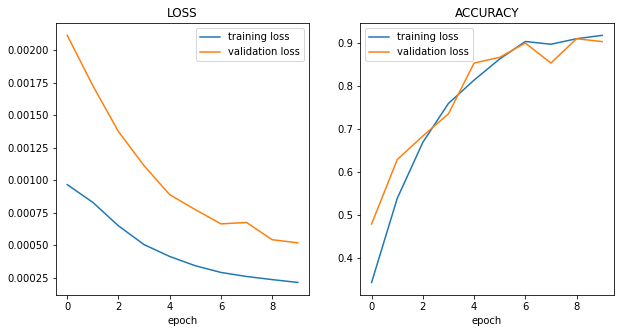

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history_loss, label="training loss")
axs[0].plot(history_val_loss, label="validation loss")
axs[0].legend()
axs[0].set_title("LOSS")
axs[0].set_xlabel("epoch")

axs[1].plot(history_accuracy, label="training loss")
axs[1].plot(history_val_accuracy, label="validation loss")
axs[1].legend()
axs[1].set_title("ACCURACY")
axs[1].set_xlabel("epoch")
plt.show()

In [13]:
def unknown_mapping(features, out_classes):
    return np.sum(np.mod(3*features, out_classes).astype(int), axis=1) % out_classes

out_classes = 4
features = np.random.uniform(size=(20000, 2))
labels = unknown_mapping(features, out_classes)

In [14]:
features

array([[0.35256775, 0.89169862],
       [0.15203956, 0.44008256],
       [0.87787787, 0.13512818],
       ...,
       [0.30429943, 0.94784287],
       [0.85496679, 0.62602669],
       [0.57373218, 0.88886604]])

In [15]:
features[:, 0]

array([0.35256775, 0.15203956, 0.87787787, ..., 0.30429943, 0.85496679,
       0.57373218])

In [16]:
labels

array([3, 1, 2, ..., 2, 3, 3], dtype=int32)

Number of points: 20000
Number of classes: 4

First 5 points coordinates
[[0.35256775 0.89169862]
 [0.15203956 0.44008256]
 [0.87787787 0.13512818]
 [0.2757539  0.61589579]
 [0.34382114 0.91711189]]

First 5 labels
[3 1 2 1 3]

If we display the points in a 2D plane, where each color is a class:


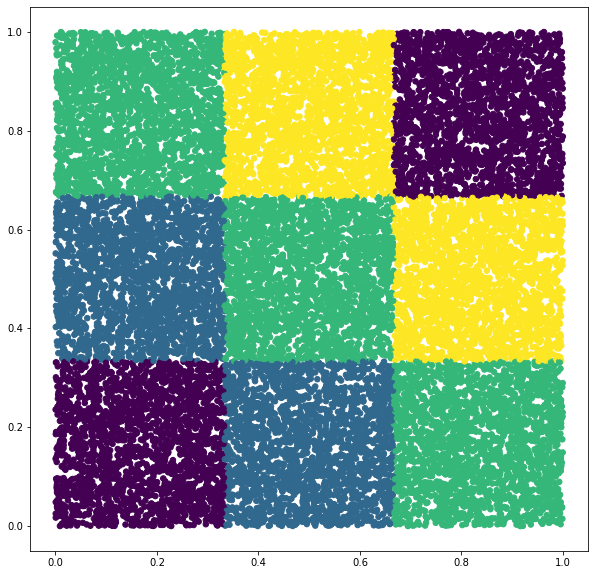

In [17]:
print(f"Number of points: {features.shape[0]}")
print(f"Number of classes: {len(np.unique(labels))}\n")
print("First 5 points coordinates")
print(features[:5, :])
print("\nFirst 5 labels")
print(labels[:5])
print("\nIf we display the points in a 2D plane, where each color is a class:")
fig, axs = plt.subplots(figsize=(10, 10))
plt.scatter(features[:, 0], features[:, 1], c=labels, s=30)
plt.show()

In [18]:
train_dataset = TensorDataset(torch.FloatTensor(features[:5000, :]), torch.LongTensor(labels[:5000]))
validation_dataset = TensorDataset(torch.FloatTensor(features[5000:, :]), torch.LongTensor(labels[5000:]))

model = NNNetwork(in_features=2, out_classes=4)

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, 
                      weight_decay=0.0005)

In [19]:
epochs = 50
batch_size = 512
history_loss, history_val_loss, history_accuracy, history_val_accuracy = train(train_dataset, validation_dataset, model, loss, optimizer, epochs, batch_size)

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.83it/s]

epoch: 1


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.27it/s]

train loss   0.0025533919572830197         val loss  0.002248491470019023          
train acc    42.600%                       val acc   50.753%                       
epoch: 2


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.86it/s]

train loss   0.0020926952362060546         val loss  0.0018597328344980878         
train acc    58.080%                       val acc   61.447%                       
epoch: 3


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.90it/s]

train loss   0.001699619698524475          val loss  0.001408632636070252          
train acc    63.800%                       val acc   71.427%                       
epoch: 4


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.96it/s]

train loss   0.0012404510974884033         val loss  0.0010423189004262288         
train acc    77.140%                       val acc   83.487%                       
epoch: 5


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.96it/s]

train loss   0.0009611593067646026         val loss  0.0009050753513971965         
train acc    82.880%                       val acc   82.467%                       
epoch: 6


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.66it/s]

train loss   0.0008388054132461547         val loss  0.0008195637027422587         
train acc    83.000%                       val acc   83.313%                       
epoch: 7


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.54it/s]

train loss   0.0007881901025772093         val loss  0.0007597708443800608         
train acc    83.280%                       val acc   83.760%                       
epoch: 8


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

train loss   0.0007391251385211945         val loss  0.0007375095367431643         
train acc    84.120%                       val acc   84.260%                       
epoch: 9


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.48it/s]

train loss   0.0007486402153968812         val loss  0.0007569781343142192         
train acc    83.540%                       val acc   82.607%                       
epoch: 10


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

train loss   0.0007299879133701324         val loss  0.0006577958305676779         
train acc    83.900%                       val acc   85.873%                       
epoch: 11


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.09it/s]

train loss   0.0006577462434768679         val loss  0.0006287633299827577         
train acc    85.940%                       val acc   86.820%                       
epoch: 12


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.87it/s]

train loss   0.0006132766544818878         val loss  0.000620706593990326          
train acc    86.860%                       val acc   86.987%                       
epoch: 13


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.14it/s]

train loss   0.0006141376793384551         val loss  0.0006314665138721467         
train acc    87.040%                       val acc   86.607%                       
epoch: 14


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.43it/s]

train loss   0.0005990305840969085         val loss  0.0005922177155812581         
train acc    87.100%                       val acc   87.580%                       
epoch: 15


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.60it/s]

train loss   0.000583287101984024          val loss  0.0006047239114840825         
train acc    87.800%                       val acc   87.713%                       
epoch: 16


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.17it/s]

train loss   0.0005691507697105408         val loss  0.0005374589790900549         
train acc    88.500%                       val acc   89.287%                       
epoch: 17


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.70it/s]

train loss   0.0005297987848520279         val loss  0.0005236339509487152         
train acc    88.820%                       val acc   89.373%                       
epoch: 18


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.12it/s]

train loss   0.0005085210531949997         val loss  0.0005199316203594208         
train acc    89.840%                       val acc   88.980%                       
epoch: 19


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.63it/s]

train loss   0.0005192038744688033         val loss  0.0005517158597707748         
train acc    89.340%                       val acc   87.253%                       
epoch: 20


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.70it/s]

train loss   0.0004971298843622207         val loss  0.00047994218866030376        
train acc    89.640%                       val acc   89.987%                       
epoch: 21


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.51it/s]

train loss   0.000466489040851593          val loss  0.00047595979770024616        
train acc    90.480%                       val acc   89.947%                       
epoch: 22


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.22it/s]

train loss   0.00045758881568908695        val loss  0.0005082778563102086         
train acc    90.960%                       val acc   88.460%                       
epoch: 23


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.08it/s]

train loss   0.00044018652737140654        val loss  0.00042719019055366517        
train acc    91.620%                       val acc   91.480%                       
epoch: 24


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.06it/s]

train loss   0.00041124935448169707        val loss  0.0004025573154290517         
train acc    92.940%                       val acc   93.173%                       
epoch: 25


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.57it/s]

train loss   0.0003961391359567642         val loss  0.00039829362432161977        
train acc    93.080%                       val acc   92.620%                       
epoch: 26


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.86it/s]

train loss   0.000386796373128891          val loss  0.00039093496898810076        
train acc    93.280%                       val acc   92.480%                       
epoch: 27


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.42it/s]

train loss   0.00038281809389591214        val loss  0.0003908013592163722         
train acc    93.100%                       val acc   92.700%                       
epoch: 28


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.19it/s]

train loss   0.0003614146560430527         val loss  0.00035230265259742746        
train acc    93.900%                       val acc   94.660%                       
epoch: 29


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.25it/s]

train loss   0.00036443856358528133        val loss  0.00036679964562257126        
train acc    93.420%                       val acc   93.380%                       
epoch: 30


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.90it/s]

train loss   0.00034451190531253813        val loss  0.00036515714724858595        
train acc    94.160%                       val acc   92.927%                       
epoch: 31


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.11it/s]

train loss   0.00033768809735774995        val loss  0.00033461960951487225        
train acc    94.640%                       val acc   94.833%                       
epoch: 32


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.33it/s]

train loss   0.00032066542804241177        val loss  0.00031603699922561643        
train acc    95.320%                       val acc   95.240%                       
epoch: 33


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.54it/s]

train loss   0.00032120513021945954        val loss  0.00033038259545962014        
train acc    95.000%                       val acc   94.653%                       
epoch: 34


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.66it/s]

train loss   0.00031632973849773406        val loss  0.0003192766298850377         
train acc    94.820%                       val acc   94.553%                       
epoch: 35


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.33it/s]

train loss   0.000300042062997818          val loss  0.00035797535578409827        
train acc    95.220%                       val acc   92.833%                       
epoch: 36


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.54it/s]

train loss   0.0003362736165523529         val loss  0.000361950471997261          
train acc    93.440%                       val acc   91.347%                       
epoch: 37


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.15it/s]

train loss   0.00036473454236984253        val loss  0.000323433072368304          
train acc    92.300%                       val acc   93.000%                       
epoch: 38


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.08it/s]

train loss   0.00030585252940654753        val loss  0.0002896641612052917         
train acc    94.560%                       val acc   95.333%                       
epoch: 39


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.66it/s]

train loss   0.000286631028354168          val loss  0.0003177116205294927         
train acc    95.260%                       val acc   94.300%                       
epoch: 40


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.90it/s]

train loss   0.0002761435970664024         val loss  0.0002966376046339671         
train acc    95.400%                       val acc   95.060%                       
epoch: 41


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.90it/s]

train loss   0.0002782387390732765         val loss  0.0002906423578659694         
train acc    95.600%                       val acc   94.433%                       
epoch: 42


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.42it/s]

train loss   0.0002615117818117142         val loss  0.00026191151688496265        
train acc    96.260%                       val acc   96.540%                       
epoch: 43


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.22it/s]

train loss   0.00025353427976369856        val loss  0.00027631304562091827        
train acc    96.860%                       val acc   95.227%                       
epoch: 44


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.57it/s]

train loss   0.00026209870278835295        val loss  0.000330531926949819          
train acc    95.620%                       val acc   93.347%                       
epoch: 45


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.45it/s]

train loss   0.0002678374171257019         val loss  0.0002915021538734436         
train acc    95.400%                       val acc   93.953%                       
epoch: 46


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.31it/s]

train loss   0.00029416065663099287        val loss  0.00025623106906811396        
train acc    94.080%                       val acc   96.327%                       
epoch: 47


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.70it/s]

train loss   0.000285220667719841          val loss  0.00026530415664116543        
train acc    94.680%                       val acc   95.567%                       
epoch: 48


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.47it/s]

train loss   0.0002479352071881294         val loss  0.00027455599953730904        
train acc    95.640%                       val acc   95.207%                       
epoch: 49


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  4.96it/s]

train loss   0.00023272916376590732        val loss  0.00024352307617664338        
train acc    96.940%                       val acc   96.373%                       
epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.74it/s]


train loss   0.00022600632011890413        val loss  0.0002274477059642474         
train acc    97.120%                       val acc   97.707%                       


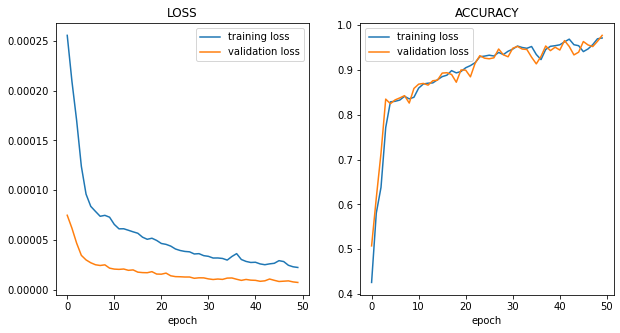

If we display the prediction on the validation set, where each color is a class:


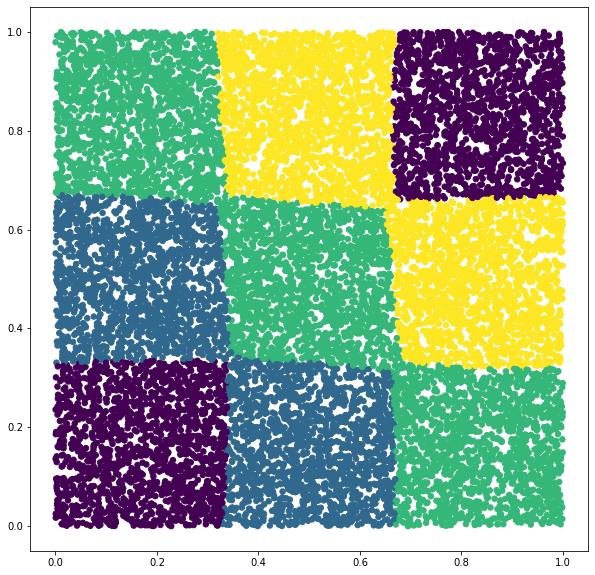

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history_loss, label="training loss")
axs[0].plot(history_val_loss, label="validation loss")
axs[0].legend()
axs[0].set_title("LOSS")
axs[0].set_xlabel("epoch")

axs[1].plot(history_accuracy, label="training loss")
axs[1].plot(history_val_accuracy, label="validation loss")
axs[1].legend()
axs[1].set_title("ACCURACY")
axs[1].set_xlabel("epoch")
plt.show()

print("If we display the prediction on the validation set, where each color is a class:")
fig, axs = plt.subplots(figsize=(10, 10))
prediction = model(torch.FloatTensor(features[5000:, :])).detach().numpy()
plt.scatter(features[5000:, 0], features[5000:, 1], c=np.argmax(prediction, axis=1), s=30)
plt.show()
